In [42]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import GARCH, ARCH, Naive, AutoARIMA, AutoCES, AutoETS, AutoTheta
from datasetsforecast.losses import mae
import warnings

In [43]:
warnings.filterwarnings("ignore")

In [44]:
ticker = ['IBM'] 
df = yf.download(ticker, start = '2018-01-01', end = '2022-12-31', interval='1d')
df = df['Adj Close']
df = df.reset_index()

print(df.head())

[*********************100%%**********************]  1 of 1 completed

        Date   Adj Close
0 2018-01-02  108.470909
1 2018-01-03  111.452553
2 2018-01-04  113.709892
3 2018-01-05  114.265396
4 2018-01-08  114.954559


In [45]:
prices = df[['Date', 'Adj Close']]
prices = prices.rename(columns={'Date':'ds', 'Adj Close': 'y'})
prices = prices.dropna()

prices["unique_id"] = "IBM"
prices.columns = ["ds", "y", "unique_id"]
prices

,ds,y,unique_id
0,2018-01-02,108.470909,IBM
1,2018-01-03,111.452553,IBM
2,2018-01-04,113.709892,IBM
3,2018-01-05,114.265396,IBM
4,2018-01-08,114.954559,IBM
...,...,...,...
1254,2022-12-23,132.414154,IBM
1255,2022-12-27,133.133942,IBM
1256,2022-12-28,130.890427,IBM
1257,2022-12-29,131.862625,IBM


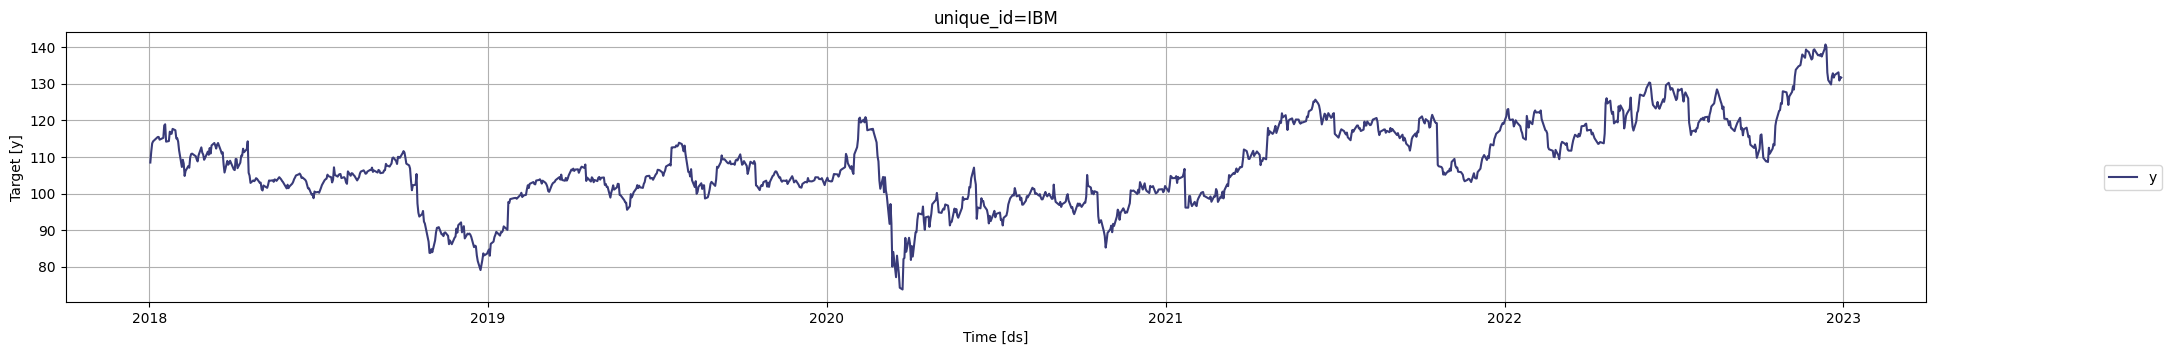

In [46]:
StatsForecast.plot(prices)

In [47]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns

,unique_id,ds,y
0,IBM,2018-01-02,NaN
1,IBM,2018-01-03,0.027117
2,IBM,2018-01-04,0.020051
3,IBM,2018-01-05,0.004873
4,IBM,2018-01-08,0.006013
...,...,...,...
1254,IBM,2022-12-23,0.005451
1255,IBM,2022-12-27,0.005421
1256,IBM,2022-12-28,-0.016995
1257,IBM,2022-12-29,0.007400


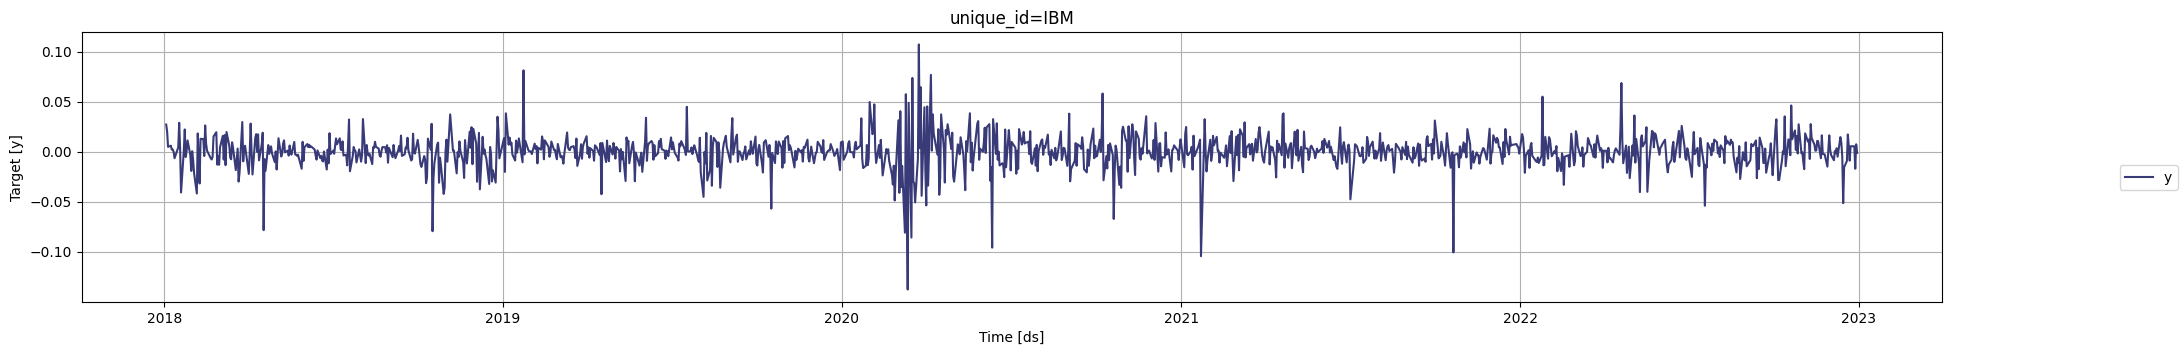

In [48]:
StatsForecast.plot(returns)

In [51]:
models = [AutoARIMA()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'D',
    n_jobs = -1
)

In [52]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [53]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,AutoARIMA
0,IBM,2022-12-14,2022-12-13,-0.004726,-0.001313
1,IBM,2022-12-15,2022-12-13,-0.051343,0.001661
2,IBM,2022-12-16,2022-12-13,-0.015574,-0.001748
3,IBM,2022-12-19,2022-12-16,-0.009246,0.001418
4,IBM,2022-12-20,2022-12-16,0.017206,-0.002216


In [57]:
crossvalidation_df.tail()

,unique_id,ds,cutoff,actual,AutoARIMA
7,IBM,2022-12-23,2022-12-21,0.005451,0.003160
8,IBM,2022-12-27,2022-12-21,0.005421,-0.003145
9,IBM,2022-12-28,2022-12-27,-0.016995,0.002174
10,IBM,2022-12-29,2022-12-27,0.007400,-0.001496
11,IBM,2022-12-30,2022-12-27,-0.001206,0.000692


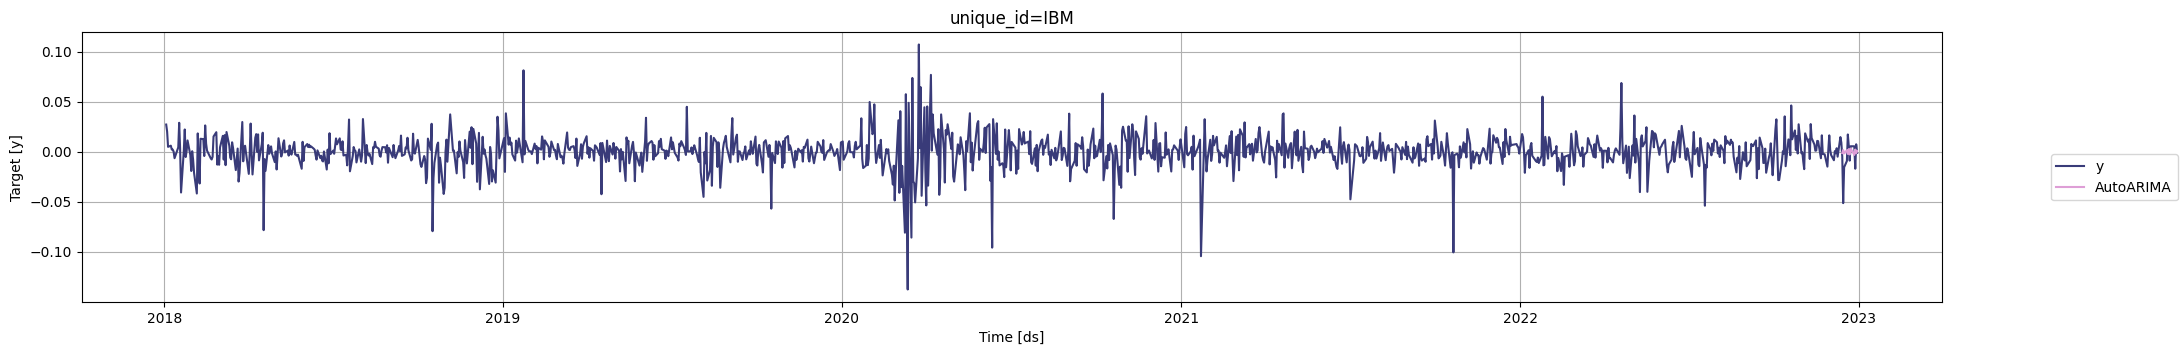

In [54]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [55]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae

,AutoARIMA
unique_id,
IBM,0.012565
